# From NumPy to PyTorch

In the previous notebook, we implemented a 2-2-1 neural network from scratch using NumPy. We had to:

1. Manually implement the forward pass
2. Manually calculate gradients for backpropagation
3. Manually implement the weight updates

In this notebook, we'll take a closer look at step 2: calculating gradients for backpropagation. We will use PyTorch to automatically compute these gradients for us, but, we will print out all the intermediate results and compare those to the manual calculations we did in the previous notebook.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from dataclasses import dataclass

## Define the PyTorch Model

Note that this is from the previous notebook. Last time, we trained it and compared it to NumpyNN. Now, we no longer want to fully train it: we simply inspect how PyTorch handles the forward and backward passes.


In [2]:
class PyTorchNNInspectable(nn.Module):
    """Same as PyTorchNN but stores intermediate activations. 
    
    We also needed to fiddle with the sigmoid slightly to access the pre-activation values."""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
        
        # Store intermediate values
        self.Z1 = None
        self.A1 = None
        self.Z2 = None
    
    def forward(self, x):
        self.Z1 = self.fc1(x)
        self.A1 = torch.sigmoid(self.Z1)
        self.Z2 = self.fc2(self.A1)
        output = torch.sigmoid(self.Z2)
        return output

## Step 1: Create a Fresh Model and Single Sample

Let's use a single sample from our XOR dataset to trace the backward pass clearly.

In [ ]:
# Use a single sample: [0, 1] -> 1 (should output 1 for XOR)
x_sample = torch.tensor([[0.0, 1.0]], requires_grad=False)
y_sample = torch.tensor([[1.0]], requires_grad=False)

# Instantiate the inspectable model
inspect_model = PyTorchNNInspectable()
A0 = x_sample
W1 = inspect_model.fc2.weight
A2 = inspect_model(x_sample) # Forward pass to populate A1, Z1, Z2

A1 = inspect_model.A1
Z1 = inspect_model.Z1
Z2 = inspect_model.Z2

## Step 2: Compute Loss and Backward Pass

Now let's compute the loss and call `backward()` to let PyTorch compute all the gradients.

Running this cell will populate the `.grad` attributes of all parameters in `inspect_model`. This will allow us to later on compare these gradients to our manual calculations.

In [5]:
# Compute loss
criterion = nn.BCELoss()
loss = criterion(A2, y_sample)

print(f"Loss: {loss.item():.7f}")

# Perform backward pass
loss.backward()

Loss: 0.8046271


### Step 3: Mimic our NumPy Implementation

Let's manually compute the gradients to verify PyTorch got it right! Or maybe.. that we got it right. 

For reference, the relating functions are:

```python
    def backward(self, target):
        self.dZ2 = self.A2 - target
        dA1 = self.dZ2.dot(self.W1.T)
        self.dZ1 = dA1 * self.sigmoid_derivative(self.A1)
    
    def optimize(self):
        self.W1 -= self.learning_rate * self.A1.T.dot(self.dZ2)
        self.b1 -= self.learning_rate * self.dZ2
        
        self.W0 -= self.learning_rate * self.A0.T.dot(self.dZ1)
        self.b0 -= self.learning_rate * self.dZ1
```

Let's mimic this as closely as possible. Since we are not using the class, the syntax would end up lacking the `self.` part. We will mock the instance variables with a dataclass.

In [6]:
# This cell is just for mockery purposes
# Focus on understanding the next cell!
@dataclass
class MockedInstanceVariables:
    A0: np.ndarray
    A1: np.ndarray
    A2: np.ndarray
    W1: np.ndarray
    dZ1: np.ndarray | None = None
    dZ2: np.ndarray | None = None

    def sigmoid_derivative(self, x):
        return x * (1 - x)

self = MockedInstanceVariables(
    A0=A0.detach().numpy(),
    A1=A1.detach().numpy(), # type: ignore
    A2=A2.detach().numpy(),
    W1=W1.detach().numpy())

# --- This was a given argument for the backward pass ---
target = y_sample.detach().numpy()

## Backpropagation (manual)

Compute gradients layer by layer (output → input)

### Step 1: Output Layer Error

Compute the gradient at the output layer. For Binary Cross-Entropy loss with sigmoid activation:

$$\frac{\partial L}{\partial Z_2} = A_2 - y$$

This is the "error signal" at the output layer, giving a value for: how far our prediction is from the target.

### Step 2: Backpropagate to Hidden Layer

Propagate the error backward through the network using the chain rule:

1. First, propagate through the weights: $\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} \cdot W_1$
2. Then apply the activation derivative: $\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \odot \sigma'(A_1)$

where $\sigma'(x) = x(1-x)$ for sigmoid and $\odot$ denotes element-wise multiplication.

### Step 3: Compute Output Layer Weight Gradients

Calculate how much each weight and bias in the output layer contributed to the loss:

$$\frac{\partial L}{\partial W_1} = A_1^T \cdot \frac{\partial L}{\partial Z_2}$$
$$\frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial Z_2}$$

### Step 4: Compute Hidden Layer Weight Gradients

Calculate how much each weight and bias in the hidden layer contributed to the loss:

$$\frac{\partial L}{\partial W_0} = A_0^T \cdot \frac{\partial L}{\partial Z_1}$$
$$\frac{\partial L}{\partial b_0} = \frac{\partial L}{\partial Z_1}$$

Note: We transpose the results to match PyTorch's weight matrix shape convention (out_features, in_features).

In [7]:
# Step 1
self.dZ2 = self.A2 - target

# Step 2
dA1 = np.dot(self.dZ2, self.W1)
self.dZ1 = dA1 * self.sigmoid_derivative(self.A1)

# Step 3
dW1_manual = self.A1.T.dot(self.dZ2)
dW1_manual = dW1_manual.T # Transpose to match PyTorch shape
db1_manual = self.dZ2

# Step 4
dW0_manual = self.A0.T.dot(self.dZ1) # type: ignore
dW0_manual = dW0_manual.T # Transpose to match PyTorch shape
db0_manual = self.dZ1

# Step N
# If we had more layers, we would continue propagating dZ backwards
# through the network.

print("\n=== MANUAL GRADIENTS (should match PyTorch) ===")
print(f"\ndW1 (dL/dW1): \n{dW1_manual}")
print(f"\ndb1 (dL/db1): \n{db1_manual}")
print(f"\ndW0 (dL/dW0): \n{dW0_manual}")
print(f"\ndb0 (dL/db0): \n{db0_manual}")


=== MANUAL GRADIENTS (should match PyTorch) ===

dW1 (dL/dW1): 
[[-0.18257074 -0.3948923 ]]

db1 (dL/db1): 
[[-0.55274534]]

dW0 (dL/dW0): 
[[ 0.         -0.04744867]
 [ 0.         -0.01343453]]

db0 (dL/db0): 
[[-0.04744867 -0.01343453]]


### Step 5: Compare PyTorch vs Manual Gradients

Let's verify that PyTorch's automatic gradients match our manual calculations!

In [10]:
# Compare fc2 (W1, b1)
pytorch_dW1 = inspect_model.fc2.weight.grad.numpy()
pytorch_db1 = inspect_model.fc2.bias.grad.numpy()

print("fc2.weight gradient:")
print(f"  PyTorch:  {pytorch_dW1}")
print(f"  Manual:   {dW1_manual}")
print(f"  Match: {np.allclose(pytorch_dW1, dW1_manual)}")

print("\nfc2.bias gradient:")
print(f"  PyTorch:  {pytorch_db1}")
print(f"  Manual:   {db1_manual.flatten()}")
print(f"  Match: {np.allclose(pytorch_db1, db1_manual.flatten())}")

# Compare fc1 (W0, b0)
pytorch_dW0 = inspect_model.fc1.weight.grad.numpy()
pytorch_db0 = inspect_model.fc1.bias.grad.numpy()

print("\nfc1.weight gradient (flatted for readability):")
print(f"  PyTorch:  {pytorch_dW0.flatten()}")
print(f"  Manual:   {dW0_manual.flatten()}")
print(f"  Match: {np.allclose(pytorch_dW0, dW0_manual)}")

print("\nfc1.bias gradient:")
print(f"  PyTorch:  {pytorch_db0}")
print(f"  Manual:   {db0_manual}")
print(f"  Match: {np.allclose(pytorch_db0, db0_manual)}") # type: ignore

fc2.weight gradient:
  PyTorch:  [[-0.18257074 -0.3948923 ]]
  Manual:   [[-0.18257074 -0.3948923 ]]
  Match: True

fc2.bias gradient:
  PyTorch:  [-0.55274534]
  Manual:   [-0.55274534]
  Match: True

fc1.weight gradient (flatted for readability):
  PyTorch:  [ 0.         -0.04744867  0.         -0.01343453]
  Manual:   [ 0.         -0.04744867  0.         -0.01343453]
  Match: True

fc1.bias gradient:
  PyTorch:  [-0.04744867 -0.01343453]
  Manual:   [[-0.04744867 -0.01343453]]
  Match: True


### Summary: What We Learned

**PyTorch automates backpropagation, but we can verify it matches our manual calculations!**

1. **Capturing intermediate activations**: By storing values (Z1, A1, Z2) as instance variables in our custom `forward()` method, we can inspect what happens during PyTorch's forward pass without manual computation.

2. **Accessing gradients**: After calling `loss.backward()`, PyTorch stores gradients in each parameter's `.grad` attribute:
   - `model.fc1.weight.grad` → gradient with respect to W0
   - `model.fc1.bias.grad` → gradient with respect to b0
   - `model.fc2.weight.grad` → gradient with respect to W1
   - `model.fc2.bias.grad` → gradient with respect to b1

3. **Verification**: We manually computed the same gradients using NumPy (exactly like our previous implementation) and confirmed PyTorch's automatic gradients match perfectly.

4. **The key insight**: PyTorch's `loss.backward()` performs the exact same chain rule calculations we coded manually:
   - `dZ2 = A2 - y` (for BCE + Sigmoid)
   - `dA1 = dZ2 @ W1.T`
   - `dZ1 = dA1 * sigmoid'(A1)`
   - Then computes weight/bias gradients from these

**The power of PyTorch: It handles all gradient calculations automatically and correctly, no matter how complex your architecture becomes!**

## Bonus: GraphViz Visualization of the Model

Note: this requires `graphviz` to be installed on your system. On macOS, you can install it via Homebrew:

```bash
brew install graphviz
```

On Windows... have fun.

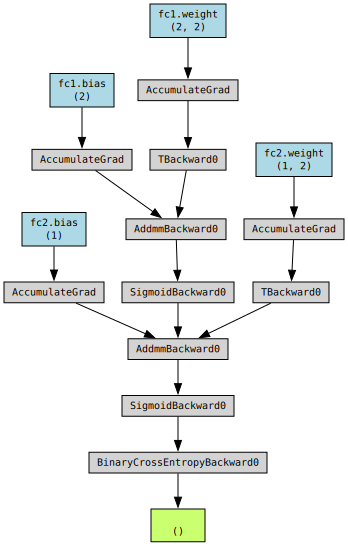

In [ ]:
# Install: pip install torchviz
from torchviz import make_dot

# After forward pass
output = inspect_model(x_sample)
loss = criterion(output, y_sample)

# Create visualization
dot = make_dot(loss, params=dict(inspect_model.named_parameters()))
# dot.render("computation_graph", format="png")
dot  # Display in Jupyter